# Import Library

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import folium
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from mlxtend.frequent_patterns import association_rules,apriori
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm
from scipy.stats import boxcox
import pmdarima as pm
from pmdarima.model_selection import train_test_split

# Import Dataset

In [88]:
df_transaction = pd.read_csv("Case Study - Transaction.csv",sep=';')
df_product = pd.read_csv("Case Study - Product.csv",sep=';')
df_customer = pd.read_csv('Case Study - Customer.csv',sep=';')
df_store = pd.read_csv('Case Study - Store.csv',sep=';')

### Data Preprocessing

##### Inkonsistensi Data

In [89]:
# Variabel Income
df_customer['Income'] = [i.replace(',','.') for i in df_customer['Income']]
df_customer['Income'] = df_customer['Income'].astype('float64')

In [90]:
# Variabel koordinat
# Mengubah koma menjadi titik pada Latitude dan Longitude
df_store['Latitude'] = df_store['Latitude'].str.replace(',', '.')
df_store['Longitude'] = df_store['Longitude'].str.replace(',', '.')

# Konversi Latitude dan Longitude menjadi float
df_store['Latitude'] = df_store['Latitude'].astype('float64')
df_store['Longitude'] = df_store['Longitude'].astype('float64')

##### Missing Value

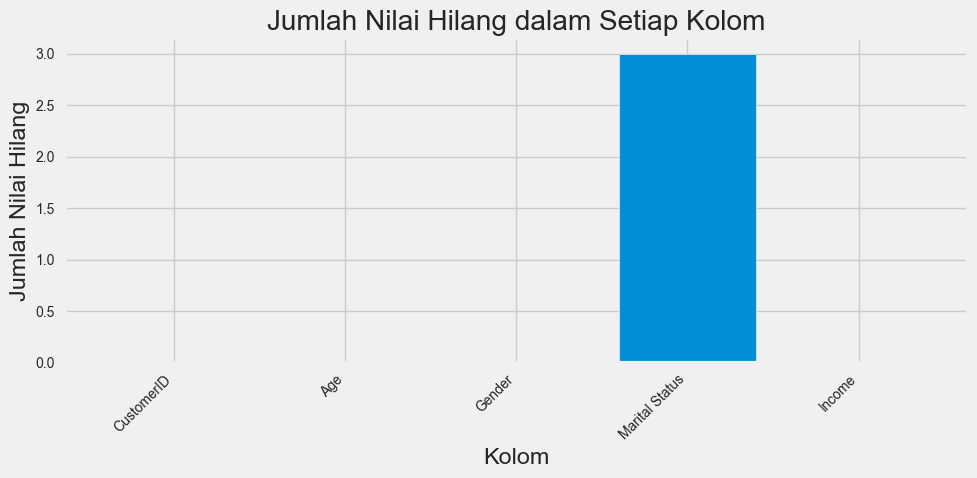

In [91]:
plt.figure(figsize=(10, 5))
plt.bar(df_customer.isna().sum().index, df_customer.isna().sum().values)
plt.xlabel('Kolom')
plt.ylabel('Jumlah Nilai Hilang')
plt.title('Jumlah Nilai Hilang dalam Setiap Kolom')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###### Imputasi NaN

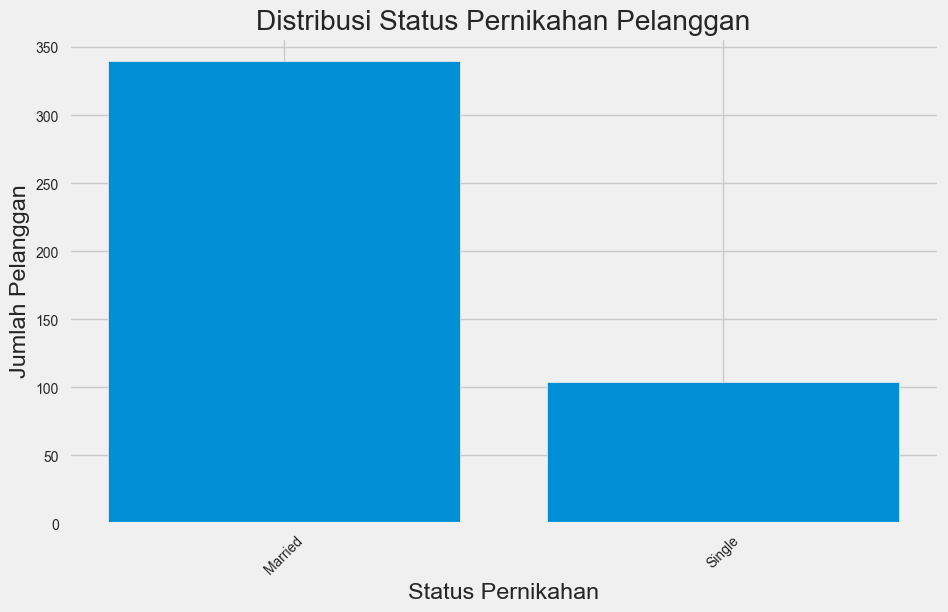

In [92]:
# Data customer dan value counts dari kolom 'Marital Status'
marital_status_counts = df_customer['Marital Status'].value_counts()

# Visualisasi menggunakan bar chart
plt.bar(marital_status_counts.index, marital_status_counts.values)
plt.xlabel('Status Pernikahan')
plt.ylabel('Jumlah Pelanggan')
plt.title('Distribusi Status Pernikahan Pelanggan')
plt.xticks(rotation=45)
plt.show()

In [93]:
df_customer[df_customer['Marital Status'].isnull()]

,CustomerID,Age,Gender,Marital Status,Income
9,10,34,1,NaN,4.00
415,416,27,1,NaN,3.43
442,443,33,1,NaN,9.28


In [94]:
df_customer = df_customer.fillna('Married')

##### Outlier Data

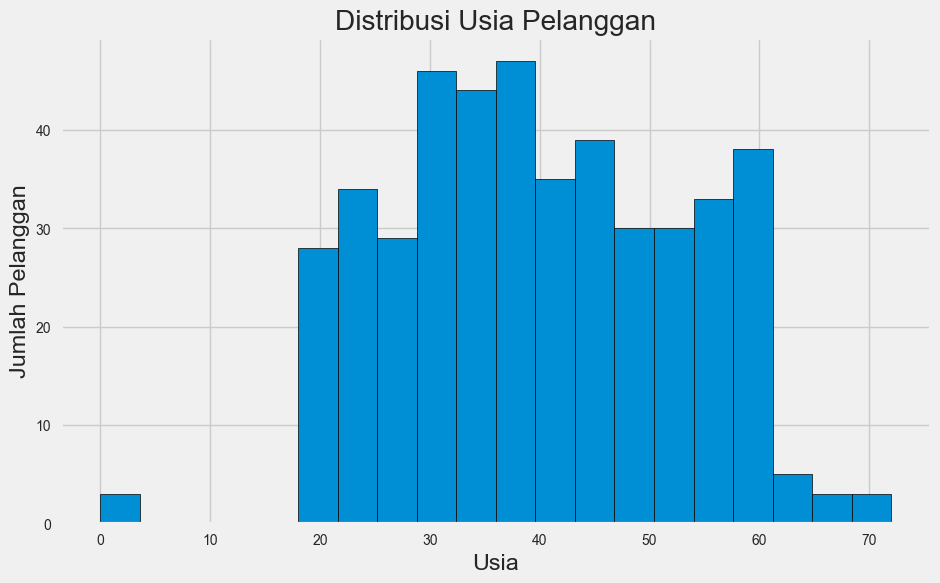

In [95]:
# Data customer dan deskripsi dari kolom 'Age'
age_data = df_customer['Age']

# Visualisasi menggunakan histogram
plt.hist(age_data, bins=20, edgecolor='black')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pelanggan')
plt.title('Distribusi Usia Pelanggan')
plt.show()


In [96]:
df_customer[df_customer['Age'] < 15]


,CustomerID,Age,Gender,Marital Status,Income
11,12,2,1,Married,4.94
73,74,3,1,Married,5.09
127,128,0,1,Married,6.77


In [97]:
df_customer.loc[df_customer['Age'] < 10, 'Age'] = df_customer['Age'].median()

### Data Merge

In [98]:
df_product = df_product[['ProductID','Product Name']]

In [99]:
df_merge = pd.merge(df_transaction, df_customer, on='CustomerID', how='inner').merge(df_store, on='StoreID', how='inner').merge(df_product, on='ProductID', how='inner')

# df_merge = df_merge.drop(columns=['CustomerID','StoreID','TransactionID','ProductID'])

In [100]:
# Konversi kolom 'tanggal' menjadi tipe data date
df_merge['Date'] = pd.to_datetime(df_merge['Date'], format='%d/%m/%Y')

df_merge.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,0,Married,10.53,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
1,TR89318,183,2022-07-17,P3,7500,1,7500,12,27,1,Single,0.18,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
2,TR9106,123,2022-09-26,P3,7500,4,30000,12,34,0,Married,4.36,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
3,TR4331,335,2022-01-08,P3,7500,3,22500,12,29,1,Single,4.74,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers
4,TR6445,181,2022-01-10,P3,7500,4,30000,12,33,1,Married,9.94,Prestasi Utama,Prestasi,General Trade,-2.990934,104.756554,Crackers


# Exploratory Data Analysis

### Visualisasi

##### Korelasi Pearson

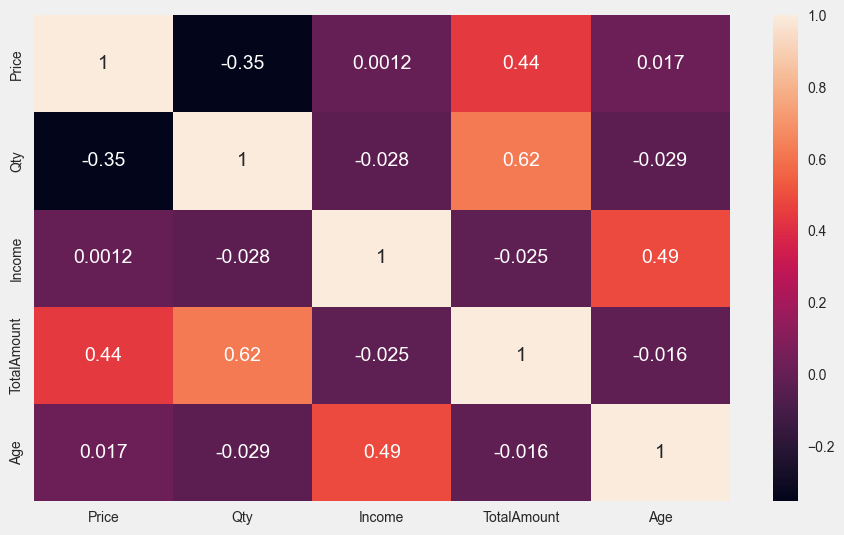

In [101]:
# Numeric Correlation
num_cols = ['Price', 'Qty', 'Income', 'TotalAmount', 'Age']
num_correlation = df_merge[num_cols].corr(numeric_only=True)

sns.heatmap(num_correlation, annot=True)
plt.show()

##### Store Mapping

In [102]:
# Membuat peta
mymap = folium.Map(location=[df_store['Latitude'].mean(), df_store['Longitude'].mean()], zoom_start=5)

# Menambahkan marker untuk setiap lokasi
for idx, row in df_store.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        tooltip=row['StoreName'],  # Menampilkan nama toko sebagai label pada marker
        icon=folium.Icon(color='blue', icon='shopping-cart', prefix='fa')
    ).add_to(mymap)

# Menampilkan peta
mymap


##### Karakteristik Pembelian

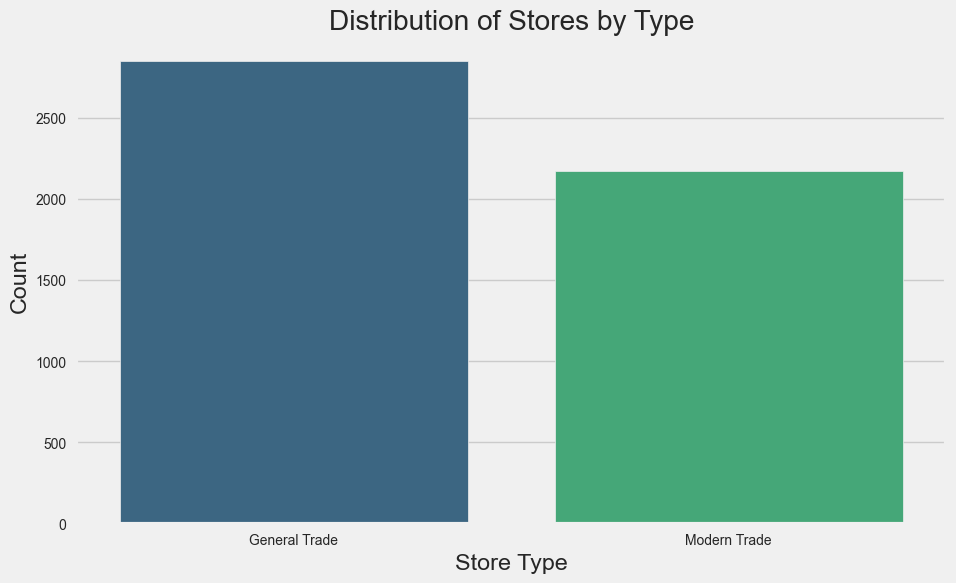

In [103]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Type', data=df_merge, palette='viridis')
plt.xlabel('Store Type')
plt.ylabel('Count')
plt.title('Distribution of Stores by Type')
plt.show()

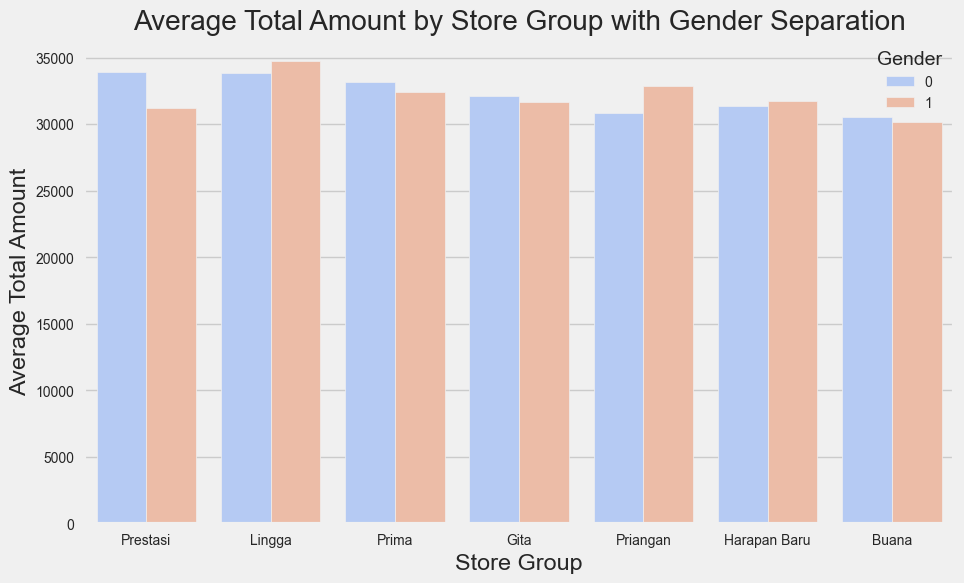

In [104]:
plt.figure(figsize=(10, 6))
sns.barplot(x='GroupStore', y='TotalAmount', hue='Gender', data=df_merge, errorbar=None, palette='coolwarm')
plt.xlabel('Store Group')
plt.ylabel('Average Total Amount')
plt.title('Average Total Amount by Store Group with Gender Separation')
plt.show()


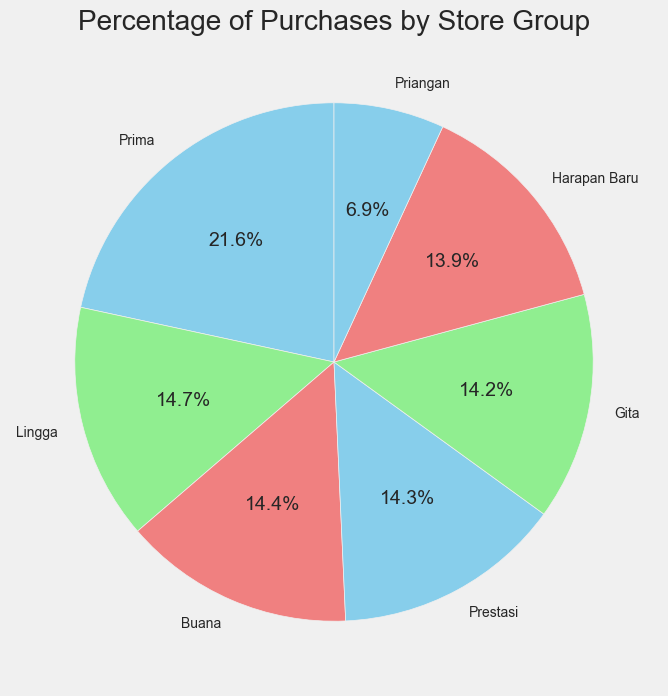

In [105]:
plt.figure(figsize=(8, 8))
store_group_purchase_count = df_merge['GroupStore'].value_counts()
store_group_purchase_count.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Percentage of Purchases by Store Group')
plt.ylabel('')
plt.show()


## Market Basket Analysis

### Data Preparation

In [106]:
df_merge['Product Name'].value_counts()

Thai Tea         814
Cheese Stick     620
Ginger Candy     530
Coffee Candy     522
Crackers         519
Yoghurt          488
Oat              485
Choco Bar        397
Potato Chip      390
Cashew           255
Name: Product Name, dtype: int64

In [107]:
item_count_pivot = df_merge.pivot_table(index='CustomerID',columns='Product Name', values= 'Qty',aggfunc='sum').fillna(0)
item_count_pivot[item_count_pivot > 0] = 1
item_count_pivot = item_count_pivot.astype('bool')
item_count_pivot.head()

Product Name,Cashew,Cheese Stick,Choco Bar,Coffee Candy,Crackers,Ginger Candy,Oat,Potato Chip,Thai Tea,Yoghurt
CustomerID,,,,,,,,,,
1,True,True,True,True,True,True,True,True,True,True
2,True,False,True,False,True,True,False,True,True,True
3,False,True,True,True,True,True,True,True,True,False
4,False,False,True,True,True,True,False,False,True,False
5,False,True,False,False,False,False,True,True,True,True


### Apriori Algorithm

In [108]:
df_transaction.TransactionID.count()

5020

In [109]:
freq = apriori(item_count_pivot, min_support= .5, use_colnames= True)
freq.sort_values('support',ascending=False).head()

,support,itemsets
7,0.841163,(Thai Tea)
0,0.727069,(Cheese Stick)
4,0.711409,(Ginger Candy )
2,0.691275,(Coffee Candy)
3,0.677852,(Crackers)


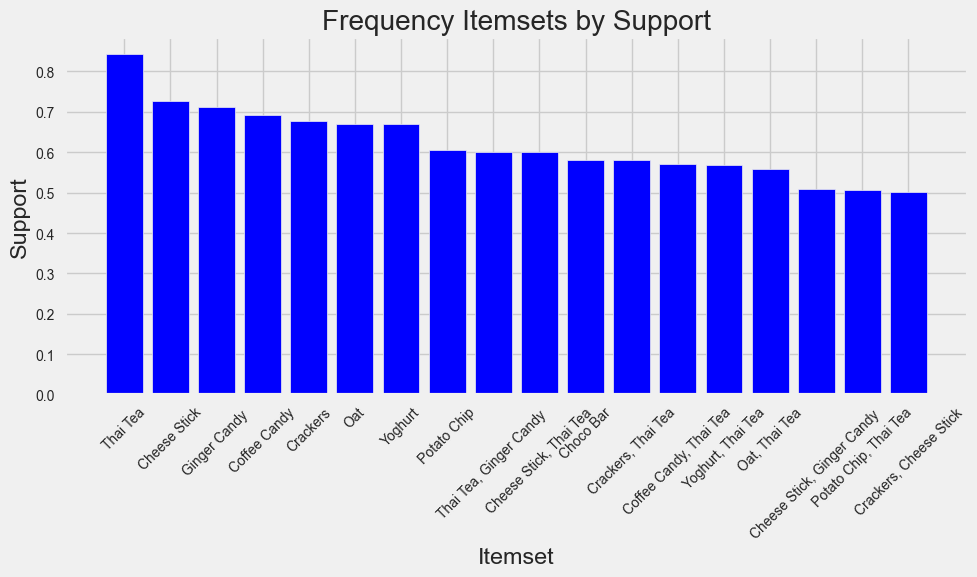

In [110]:
import matplotlib.pyplot as plt
import pandas as pd


# Mengurutkan data freq berdasarkan support
freq_sorted = freq.sort_values('support', ascending=False)

# Membuat visualisasi bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(freq_sorted)), freq_sorted['support'], color='blue')
plt.xticks(range(len(freq_sorted)), freq_sorted['itemsets'].apply(lambda x: ', '.join(x)), rotation=45)
plt.xlabel('Itemset')
plt.ylabel('Support')
plt.title('Frequency Itemsets by Support')
plt.tight_layout()
plt.show()


### Association Rule Mining

In [111]:
rules = association_rules(freq,metric='confidence',min_threshold=0.8)[['antecedents','consequents','support','confidence','lift']]
rules.sort_values(by=['support','confidence','lift'],ascending=False)

,antecedents,consequents,support,confidence,lift
3,(Ginger Candy ),(Thai Tea),0.599553,0.842767,1.001907
0,(Cheese Stick),(Thai Tea),0.599553,0.824615,0.980327
2,(Crackers),(Thai Tea),0.579418,0.854785,1.016194
1,(Coffee Candy),(Thai Tea),0.570470,0.825243,0.981073
6,(Yoghurt),(Thai Tea),0.568233,0.849498,1.009909
4,(Oat),(Thai Tea),0.557047,0.832776,0.990029
5,(Potato Chip),(Thai Tea),0.505593,0.833948,0.991423


## RFM Analysis

### Recency

In [112]:
#last date available in our dataset
df_merge['Date'].max()
now = pd.Timestamp('2022-12-31')
now

Timestamp('2022-12-31 00:00:00')

In [113]:
#group by customer by last date they purchased...
recency_df=df_merge[["CustomerID","Date"]].groupby("CustomerID",as_index=False).max()
recency_df.rename(columns ={"Date":"LastPurchaseDate"},inplace=True)
max_date=recency_df["LastPurchaseDate"].max()
recency_df["recency"]=max_date-recency_df["LastPurchaseDate"]
recency_df["recency"]=recency_df["recency"].dt.days

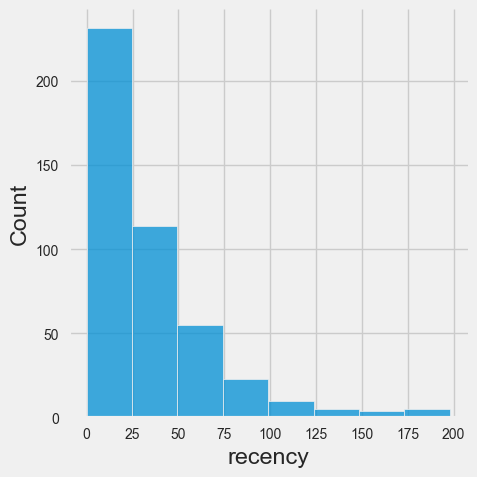

In [114]:
sns.displot(recency_df.recency,bins=8,kde=False)

In [115]:
recency_df['R'],Intervals_Recency=pd.qcut(recency_df["recency"],q=3,labels=[3,2,1],retbins=True)

In [116]:
#calculate how often he is purchasing with reference to latest date in days..

recency_df['Recency'] = recency_df.LastPurchaseDate.apply(lambda x : (now - x).days)

In [117]:
recency_df.drop(columns=['LastPurchaseDate'],inplace=True)

### Frequency

In [118]:
frequency_df = df_merge.copy()
frequency_df.drop_duplicates(subset=['CustomerID','TransactionID'], keep="first", inplace=True)
frequency_df = frequency_df.groupby('CustomerID',as_index=False)['TransactionID'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df["F"],Intervals_Frequency=pd.qcut(frequency_df["Frequency"],q=3,labels=[1,2,3],retbins=True)
frequency_df.head()

,CustomerID,Frequency,F
0,1,17,3
1,2,13,2
2,3,15,3
3,4,10,1
4,5,7,1


<AxesSubplot: xlabel='Frequency', ylabel='Count'>

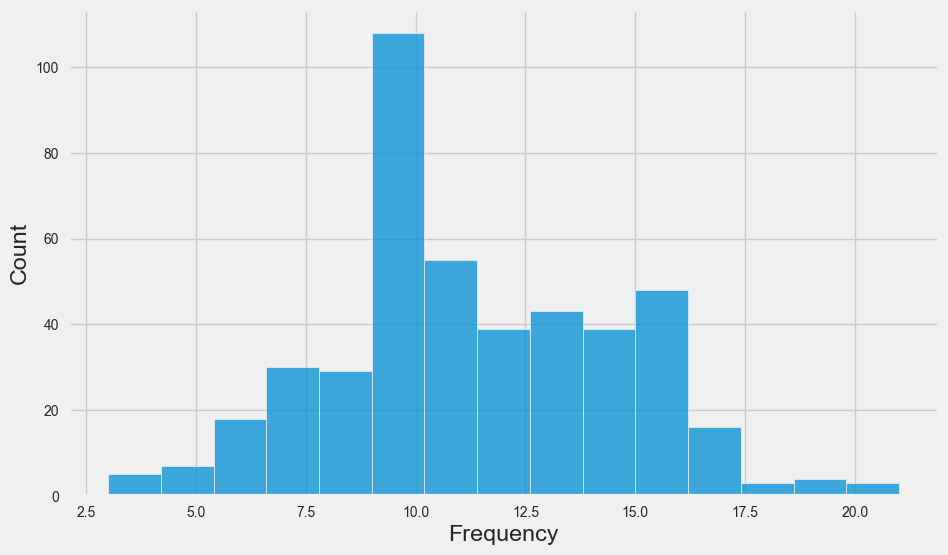

In [119]:
sns.histplot(frequency_df.Frequency,bins=15,kde=False)

### Monetary

In [120]:
monetary_df = df_merge.groupby('CustomerID',as_index=False)['TotalAmount'].sum()
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()


,CustomerID,Monetary
0,1,623300
1,2,392300
2,3,446200
3,4,302500
4,5,268600


In [121]:
monetary_df["M"],Intervals_Monetory=pd.qcut(monetary_df["Monetary"],q=3,labels=[1,2,3],retbins=True)

In [122]:
monetary_df

,CustomerID,Monetary,M
0,1,623300,3
1,2,392300,2
2,3,446200,3
3,4,302500,2
4,5,268600,1
...,...,...,...
442,443,485100,3
443,444,577700,3
444,445,587200,3
445,446,423300,3


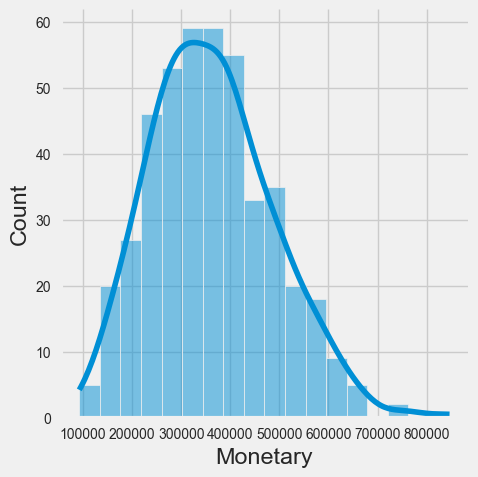

In [123]:
sns.displot(monetary_df.Monetary,kde=True)

### Result

In [124]:
rfm=pd.merge(recency_df[["CustomerID","R"]],monetary_df[["CustomerID","M"]],on="CustomerID",how="inner")
rfm=pd.merge(rfm,frequency_df[["CustomerID","F"]],on="CustomerID",how="inner")
rfm["RFM"]=(rfm["R"]).astype(str)+(rfm["F"]).astype(str)+(rfm["M"]).astype(str)

In [125]:
def Customer_Segment(data):
    if data["R"]==1 and data["F"] in [1,2,3] and (data["M"]==3):
        return "Lost Customers - Big Spenders"
    elif data["R"]== 1 and data["F"] in [1,2] and data["M"] in [1,2]:
        return "Lost Customers - Bargain"
    elif data["R"] in [1,2] and data["F"]==3 and data["M"] in [1,2]:
        return "Lost/Almost Lost Customers - Loyal"
    elif (data["R"]==3) and (data["F"]==3) and data["M"] in [1,2]:
        return "Loyal Customers"
    elif (data["R"]==3) and data["F"] in [3,2] and data["M"]==3:
        return "Big Spenders"
    elif (data["R"]==3) and (data["F"]==1) and data["M"] in [1,2,3]:
        return "New Customers"
    elif (data["R"]==3) and (data["F"]==2) and data["M"] in [1,2]:
        return "Bargain Customers"
    elif (data["R"]==2) and data["F"]==2 and data["M"] in [1,2]:
        return "Occasional Customers-Bargain"
    elif (data["R"]==2) and data["F"] in [2,3] and data["M"]==3:
        return "Occasional Customers- Big Spenders"
    elif (data["R"]==2) and data["F"]==1 and data ["M"] in [1,2,3]:
        return "Unsatisfied Customers"
    else:
        return "No Segment"

In [126]:
rfm["R"]=rfm["R"].astype("category")
rfm["F"]=rfm["F"].astype("category")
rfm["M"]=rfm["M"].astype("category")
rfm["Segment"]=rfm.apply(Customer_Segment,axis=1)
rfm.head()

,CustomerID,R,M,F,RFM,Segment
0,1,2,3,3,233,Occasional Customers- Big Spenders
1,2,2,2,2,222,Occasional Customers-Bargain
2,3,3,3,3,333,Big Spenders
3,4,3,2,1,312,New Customers
4,5,2,1,1,211,Unsatisfied Customers


In [127]:
Segment_count=(rfm.groupby("Segment",as_index=False).agg(TotalCount=("CustomerID","count"))).sort_values(by="TotalCount",ascending=True)
Segment_count

,Segment,TotalCount
4,Lost/Almost Lost Customers - Loyal,6
5,Loyal Customers,10
0,Bargain Customers,28
8,Occasional Customers-Bargain,34
3,Lost Customers - Big Spenders,38
7,Occasional Customers- Big Spenders,53
1,Big Spenders,54
6,New Customers,58
9,Unsatisfied Customers,60
2,Lost Customers - Bargain,106


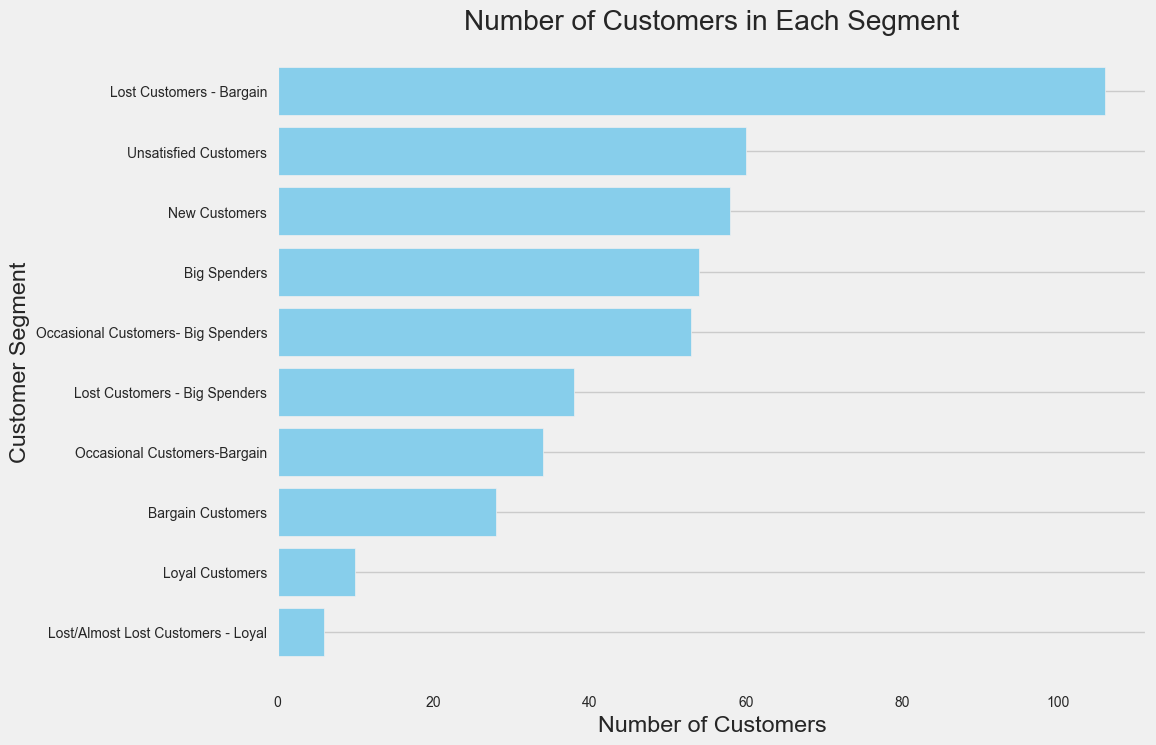

In [128]:
# Membuat bar plot horizontal
plt.figure(figsize=(10, 8))  # Perhatikan bahwa figsize sudah dibalik untuk membuat plot menjadi lebih tinggi
plt.barh(Segment_count['Segment'], Segment_count['TotalCount'], color='skyblue')  # Menggunakan barh untuk plot horizontal
plt.xlabel('Number of Customers')  # Memperbarui label x-axis menjadi 'Number of Customers'
plt.ylabel('Customer Segment')  # Memperbarui label y-axis menjadi 'Customer Segment'
plt.title('Number of Customers in Each Segment')
plt.grid(axis='x')  # Menambahkan grid pada sumbu x karena sekarang sumbu x yang berisi data jumlah pelanggan
plt.show()


## ABC Analysis

In [129]:
Revenue_ABC=df_merge.groupby(["Type","Product Name"]).agg(Total_Revenue=("TotalAmount","sum")).sort_values(by="Total_Revenue",ascending=False).reset_index()
Revenue_ABC["cum_sum"]=Revenue_ABC["Total_Revenue"].cumsum()
Revenue_ABC["cum_per"]=Revenue_ABC["cum_sum"]/Revenue_ABC["Total_Revenue"].sum()*100
Revenue_ABC["per"]=Revenue_ABC["cum_per"]-Revenue_ABC["cum_per"].shift(1)
Revenue_ABC.loc[0,"per"]=Revenue_ABC["cum_per"][0]

In [130]:
def ABC(data):
    if data["cum_per"]<=75:
        return "A"
    elif data["cum_per"]>75 and data["cum_per"]<=95:
        return "B"
    elif data["cum_per"]>95:
        return "C"

Revenue_ABC["ABC_Revenue"]=Revenue_ABC.apply(ABC,axis=1)

### Result

In [131]:
Bar_graph_Abc=Revenue_ABC[["ABC_Revenue","Product Name","Total_Revenue"]].groupby("ABC_Revenue").agg(Revenue=("Total_Revenue","sum"),count=("Product Name","count"))
Bar_graph_Abc

,Revenue,count
ABC_Revenue,,
A,118988700,12
B,34651100,6
C,8403200,2


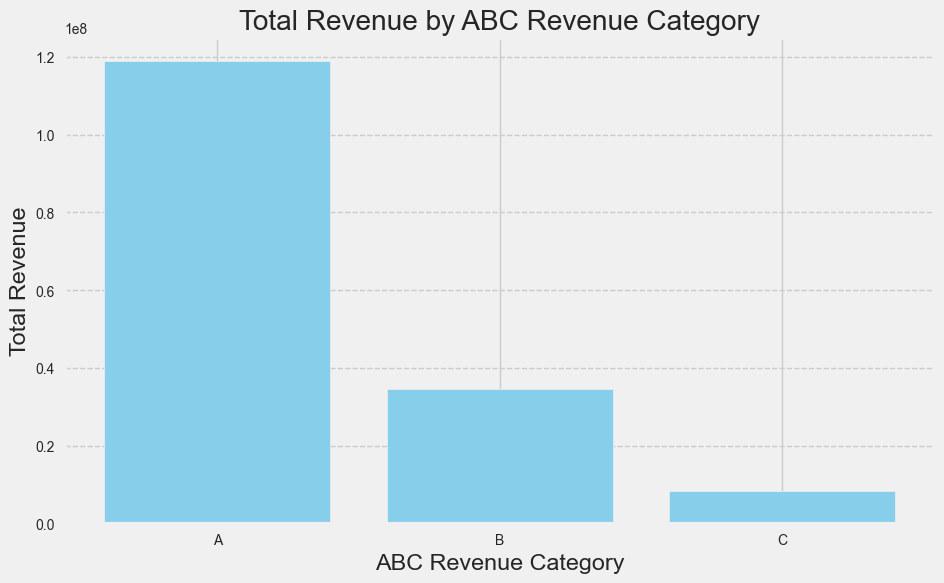

In [132]:
import pandas as pd
import matplotlib.pyplot as plt

# Contoh data Bar_graph_Abc (gantilah dengan data sesuai dengan DataFrame Bar_graph_Abc Anda)
data = {
    'ABC_Revenue': ['A', 'B', 'C'],
    'Revenue': [118988700, 34651100, 8403200],
    'count': [12, 6, 2]
}

# Membuat DataFrame dari data
Bar_graph_Abc = pd.DataFrame(data)

# Membuat visualisasi bar chart dan line chart
plt.figure(figsize=(10, 6))

# Bar chart
plt.bar(Bar_graph_Abc['ABC_Revenue'], Bar_graph_Abc['Revenue'], color='skyblue')
plt.xlabel('ABC Revenue Category')
plt.ylabel('Total Revenue')
plt.title('Total Revenue by ABC Revenue Category')
plt.grid(axis='y', linestyle='--')
plt.show()


In [133]:
Revenue_ABC.loc[Revenue_ABC['ABC_Revenue'] == "A", ['Type', 'Product Name', 'Total_Revenue', 'ABC_Revenue']]

,Type,Product Name,Total_Revenue,ABC_Revenue
0,General Trade,Cheese Stick,14475000,A
1,Modern Trade,Cheese Stick,13140000,A
2,General Trade,Coffee Candy,11392800,A
3,General Trade,Choco Bar,11290400,A
4,General Trade,Yoghurt,11070000,A
5,Modern Trade,Choco Bar,9900000,A
6,General Trade,Oat,8928000,A
7,Modern Trade,Yoghurt,8560000,A
8,Modern Trade,Coffee Candy,8319000,A
9,General Trade,Crackers,7747500,A


In [134]:
Revenue_ABC.loc[Revenue_ABC['ABC_Revenue'] == "B", ['Type', 'Product Name', 'Total_Revenue', 'ABC_Revenue']]

,Type,Product Name,Total_Revenue,ABC_Revenue
12,Modern Trade,Oat,6512000,B
13,General Trade,Cashew,6138000,B
14,Modern Trade,Potato Chip,5952000,B
15,Modern Trade,Crackers,5932500,B
16,Modern Trade,Cashew,5148000,B
17,Modern Trade,Thai Tea,4968600,B


In [135]:
Revenue_ABC.loc[Revenue_ABC['ABC_Revenue'] == "C", ['Type', 'Product Name', 'Total_Revenue', 'ABC_Revenue']]

,Type,Product Name,Total_Revenue,ABC_Revenue
18,General Trade,Ginger Candy,4963200,C
19,Modern Trade,Ginger Candy,3440000,C


# Clustering

### Data Preparation

In [136]:
df_cluster = df_merge.groupby('CustomerID').agg({
    'TransactionID': 'count',
    'Qty': 'sum',
    'TotalAmount': 'sum'
}).reset_index()


In [137]:
df_cluster = pd.merge(df_cluster,df_customer,on='CustomerID',how='inner')
df_cluster.set_index('CustomerID', inplace=True)

In [138]:
### Casting Data

df_cluster['Income'] = df_cluster['Income'].astype('float64')

### Label Encoding

In [139]:
le = LabelEncoder()
for col in df_cluster.columns:
    if df_cluster[col].dtype == 'object':
        df_cluster[col] = le.fit_transform(df_cluster[col])


In [140]:
df_cluster.head(3)

,TransactionID,Qty,TotalAmount,Age,Gender,Marital Status,Income
CustomerID,,,,,,,
1,17,60,623300,55,1,0,5.12
2,13,57,392300,60,1,0,6.23
3,15,56,446200,32,1,0,9.17


### Elbow Method

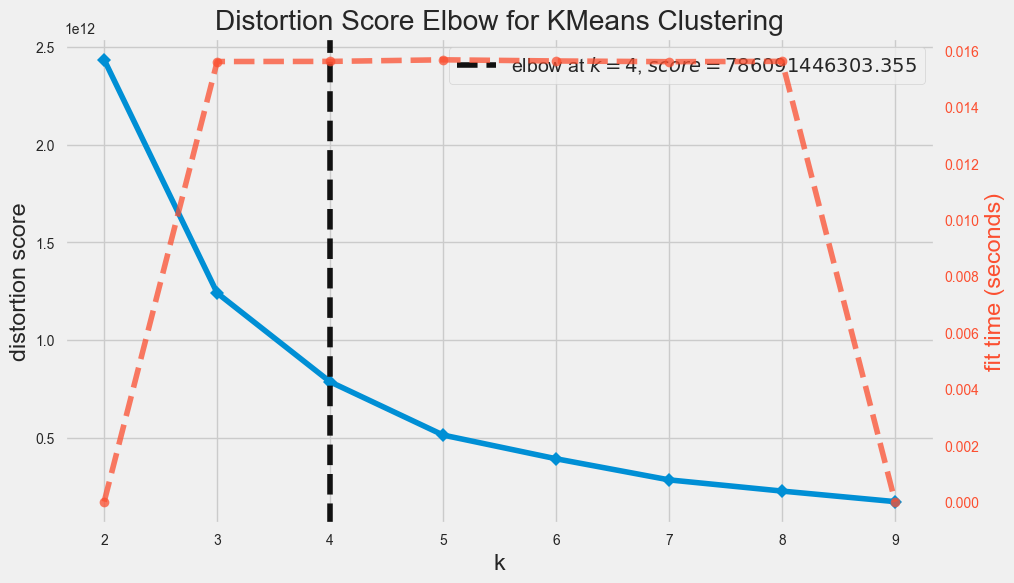

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [141]:
model = KMeans(init='k-means++',n_init = 'auto',random_state=42)
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(df_cluster)

visualizer.show()


### Model Fitting

In [142]:
kmeans = KMeans(n_clusters=4, init='k-means++',n_init='auto',random_state=42)

kmeans.fit(df_cluster)

cluster_labels = kmeans.labels_

### Silhouette Score

In [143]:
# Hitung silhouette score
silhouette_avg = silhouette_score(df_cluster, cluster_labels)

silhouette_avg

0.5179081631981589

C:\Users\LENOVO\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


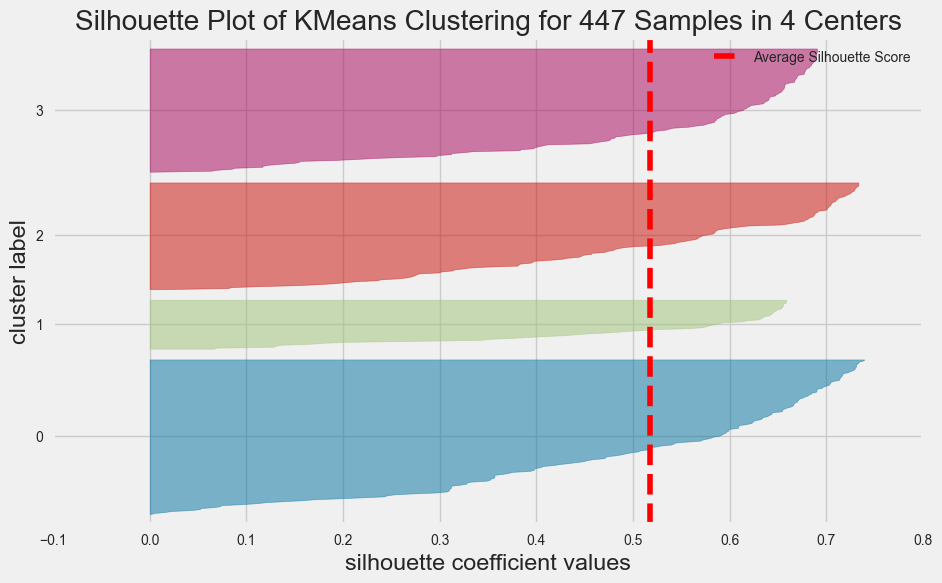

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 447 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [144]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(df_cluster)
visualizer.show()

### Visualisasi

In [145]:
df_cluster['cluster'] = cluster_labels

In [146]:
# Melakukan pengelompokan berdasarkan kolom 'cluster' dan mengambil nilai rata-rata
result = df_cluster[['TransactionID','Qty','TotalAmount','cluster','Income']].groupby('cluster').mean()

# Memutar angka rata-rata variabel 'Qty' menjadi bilangan bulat
result[['Qty','TransactionID']] = result[['Qty','TransactionID']].round(0).astype(int)

result

,TransactionID,Qty,TotalAmount,Income
cluster,,,,
0,11,39,340749.685535,8.544906
1,16,61,591511.764706,8.186078
2,13,49,450864.545455,8.450545
3,8,27,221272.440945,8.936850


In [147]:
result_modus = df_cluster[['Marital Status','Gender','cluster']].groupby('cluster').agg(pd.Series.mode)

result_modus['Marital Status']= le.inverse_transform(result_modus['Marital Status'])

result_modus['Gender'] = result_modus['Gender'].replace({0: 'Wanita', 1: 'Pria'})

result_modus

,Marital Status,Gender
cluster,,
0,Married,Wanita
1,Married,Wanita
2,Married,Wanita
3,Married,Pria


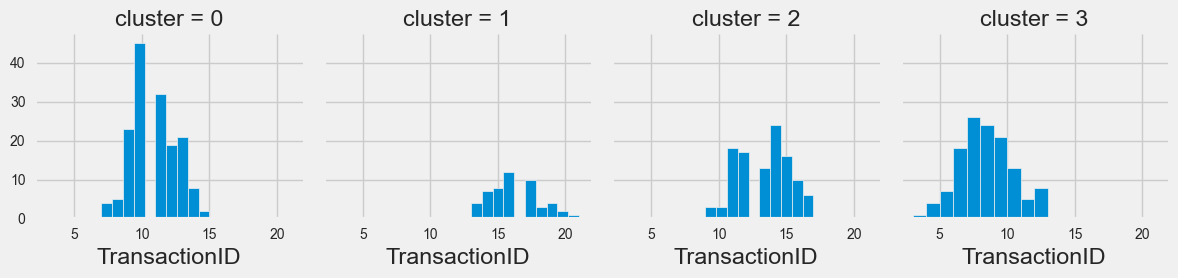

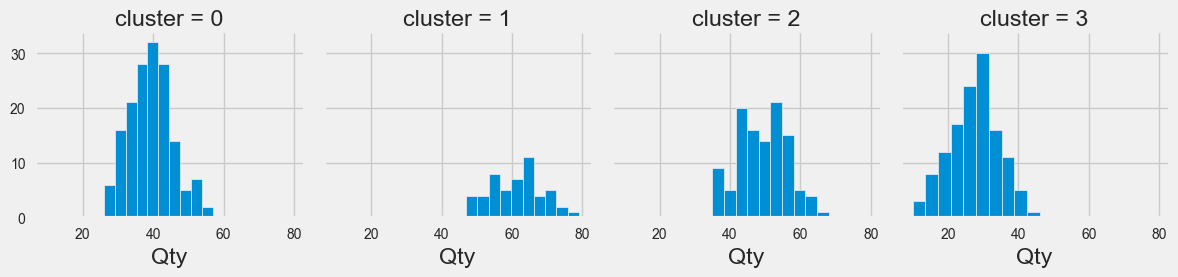

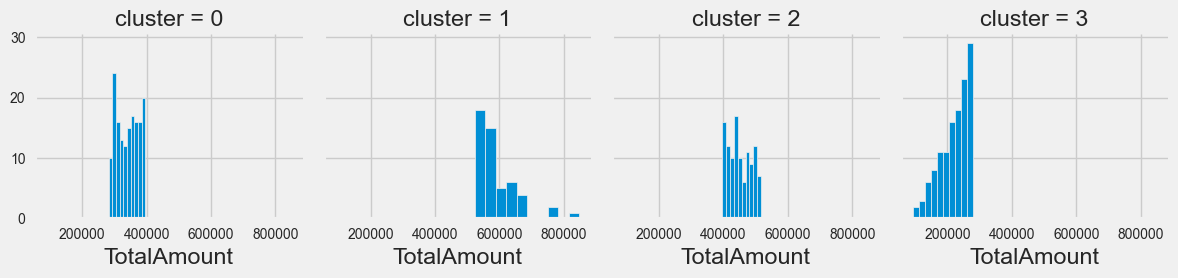

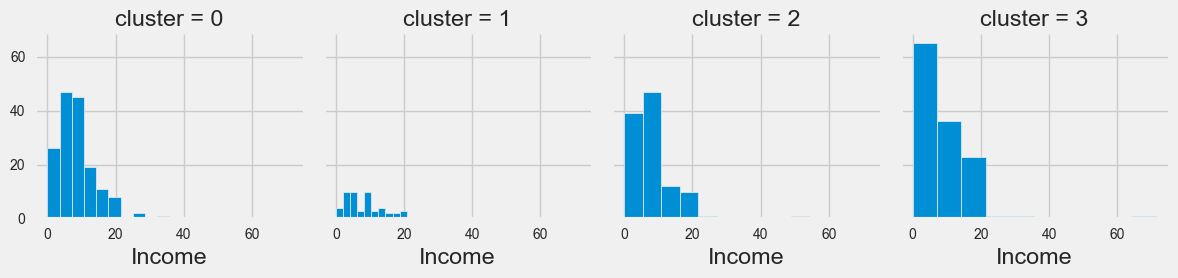

In [148]:
for c in ['TransactionID','Qty','TotalAmount','Income']:
    grid= sns.FacetGrid(df_cluster, col='cluster')
    grid.map(plt.hist, c)

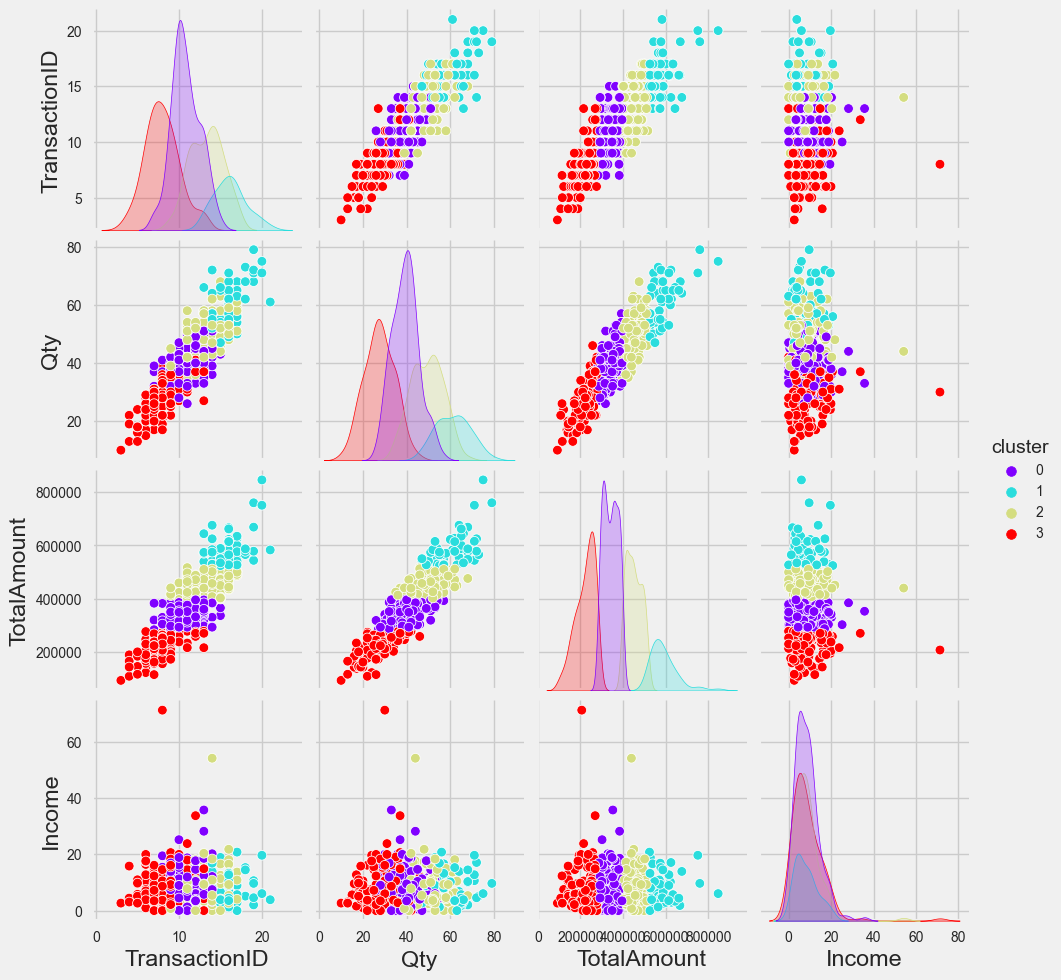

In [149]:
# Memilih kolom yang akan digunakan dalam pairplot
columns_to_use = ['TransactionID', 'Qty', 'TotalAmount', 'Income', 'cluster']

# Menyediakan DataFrame yang dipilih
df_selected = df_cluster[columns_to_use]

# Memplot pairplot dengan hue='cluster' dan palette='rainbow'
sns.pairplot(df_selected, hue='cluster', palette='rainbow')

# Model TimeSeries

### Data Preparation

In [150]:
df_arima = df_merge.groupby('Date').agg({'Qty': 'sum'}).reset_index()

df_arima.set_index('Date', inplace=True)

df_arima

,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


### Data Understanding

##### Visualisasi

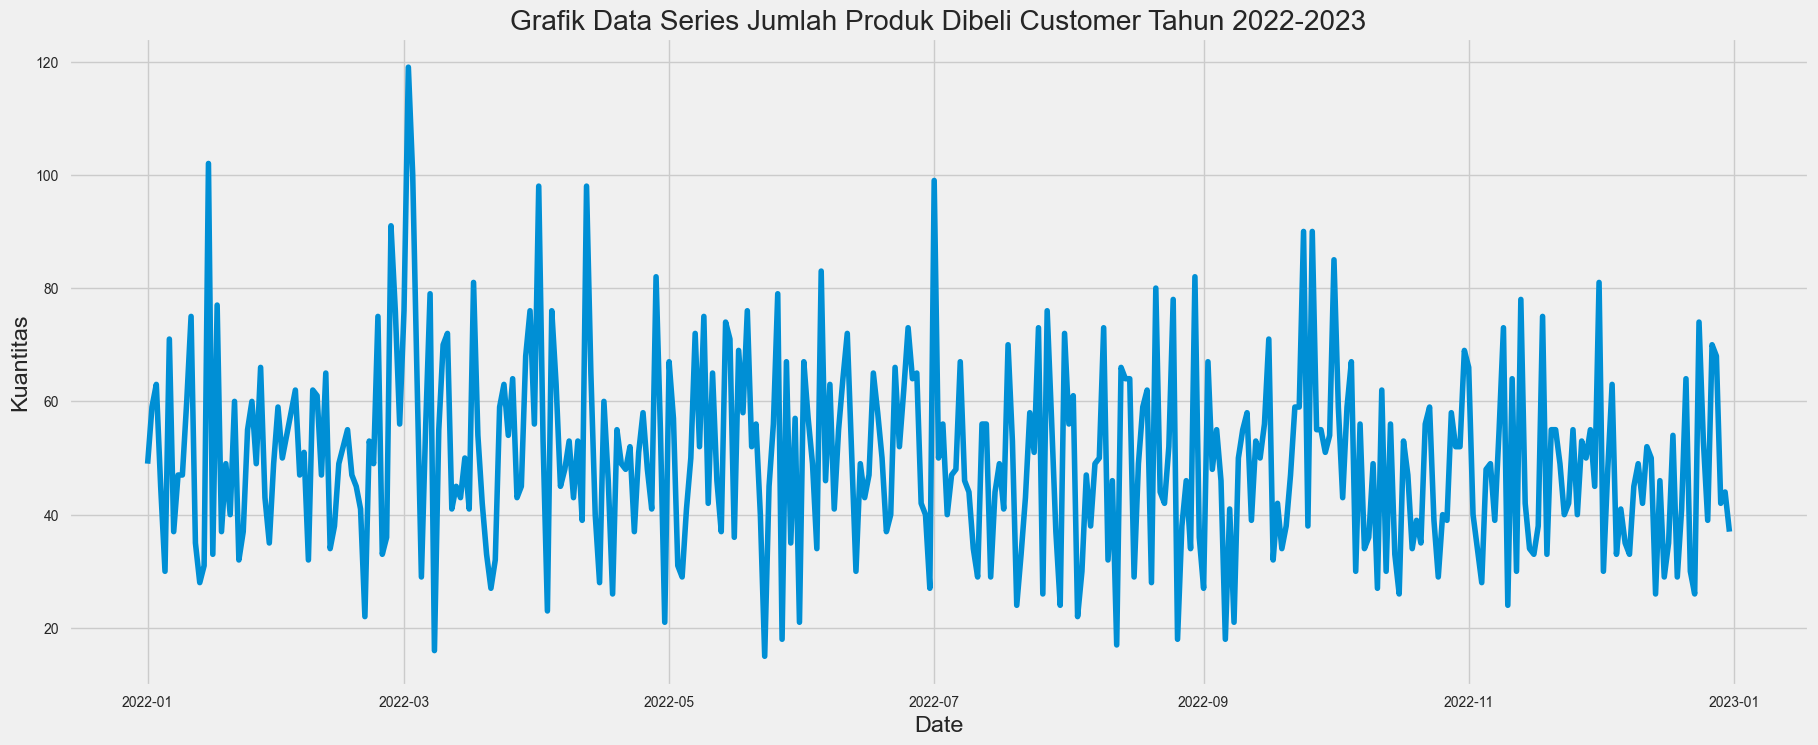

In [151]:
#plot close price
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Kuantitas')
plt.plot(df_arima['Qty'])
plt.title('Grafik Data Series Jumlah Produk Dibeli Customer Tahun 2022-2023')
plt.show()

##### Seasonal Decomposition

In [152]:
# Membuat dekomposisi time series
decomposition = sm.tsa.seasonal_decompose(df_arima, model='additive')

# Mendapatkan komponen-komponen time series
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Uji keberadaan komponen musiman
is_seasonal = (abs(seasonal - seasonal.mean()) > 0.05 * seasonal.std()).any()

if is_seasonal:
    print("Data time series bersifat musiman.")
else:
    print("Data time series tidak bersifat musiman.")

Data time series bersifat musiman.


##### Uji Stasioner

In [153]:
# definisikan fungsi untuk melakukan ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Hasil Uji: Data residu bersifat stasioner.")
    else:
        print("Hasil Uji: Data residu tidak bersifat stasioner.")

adf_test(df_arima)

ADF Statistic: -19.448086
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
Hasil Uji: Data residu bersifat stasioner.


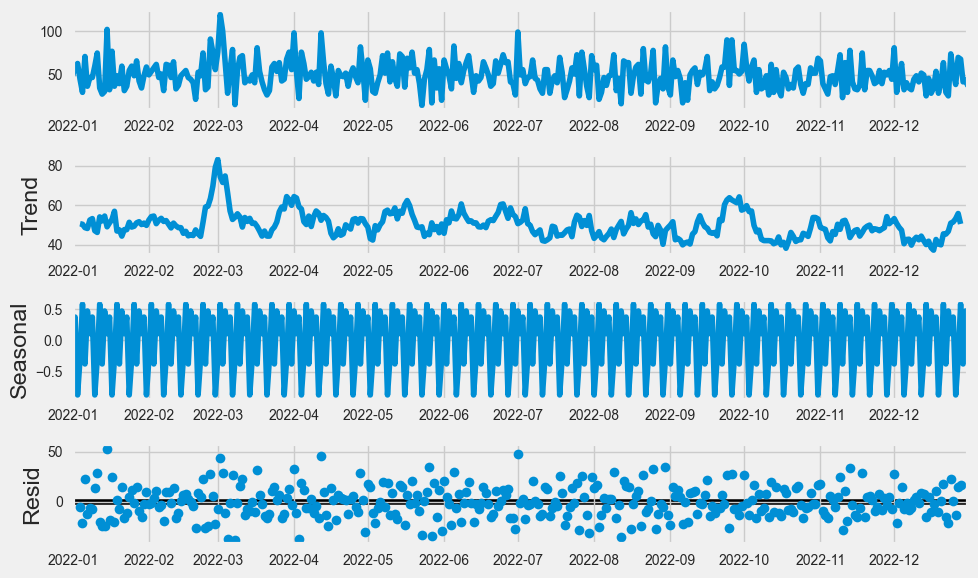

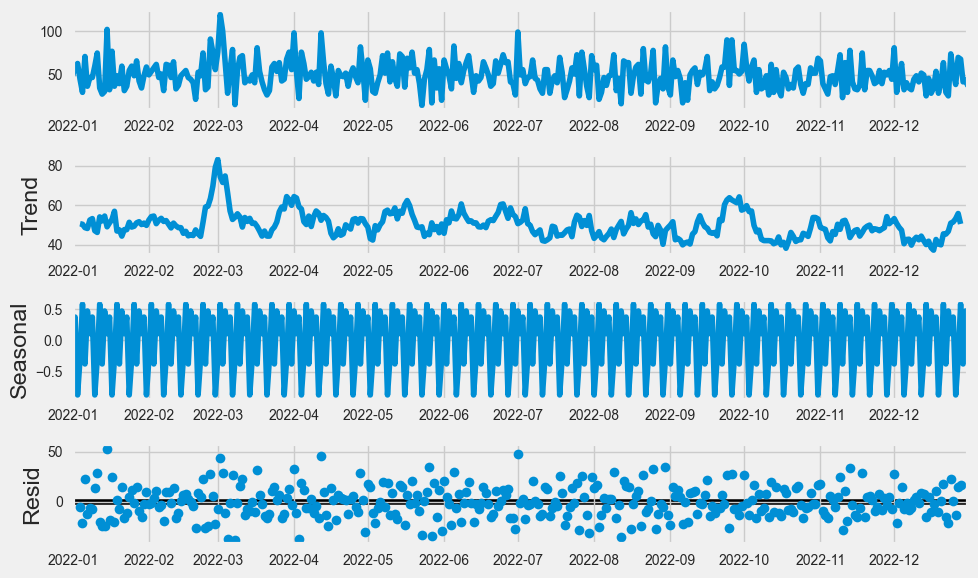

In [154]:
# Decompose the data into trend, seasonality, and residual components
result = sm.tsa.seasonal_decompose(df_arima)

# Plot the results
result.plot()

### Data Transformation

In [155]:
transformed_data, lambda_value = boxcox(df_arima['Qty'])

df_transform = df_arima.copy()
df_transform['Qty'] = transformed_data

print(f'Nilai Lambda = {round(lambda_value,3)} sehingga transformasi menggunakan √y')

Nilai Lambda = 0.426 sehingga transformasi menggunakan √y


In [156]:
# transform data √y
df_arima['Qty'] = np.sqrt(df_arima['Qty'])

##### Visualisasi

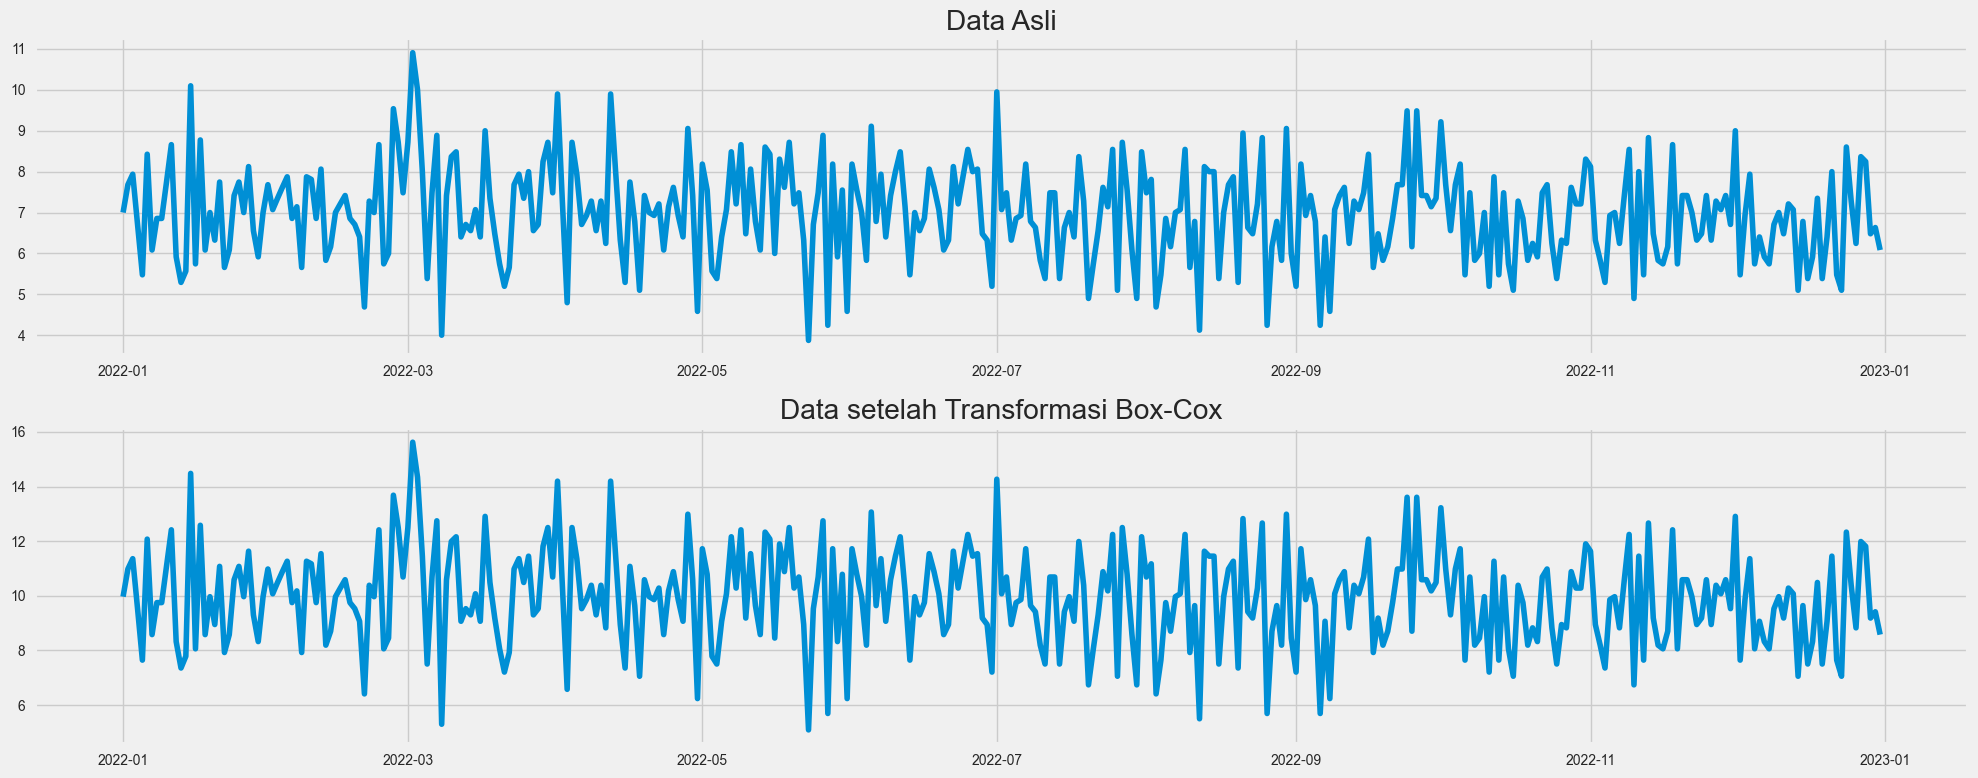

In [157]:
plt.figure(figsize=(20, 8))

# Plot data asli
plt.subplot(2, 1, 1)
plt.plot(df_arima['Qty'])
plt.title('Data Asli')

# Plot data yang telah di-transformasi menggunakan Box-Cox
plt.subplot(2, 1, 2)
plt.plot(df_transform['Qty'])
plt.title('Data setelah Transformasi Box-Cox')

plt.tight_layout()
plt.show()


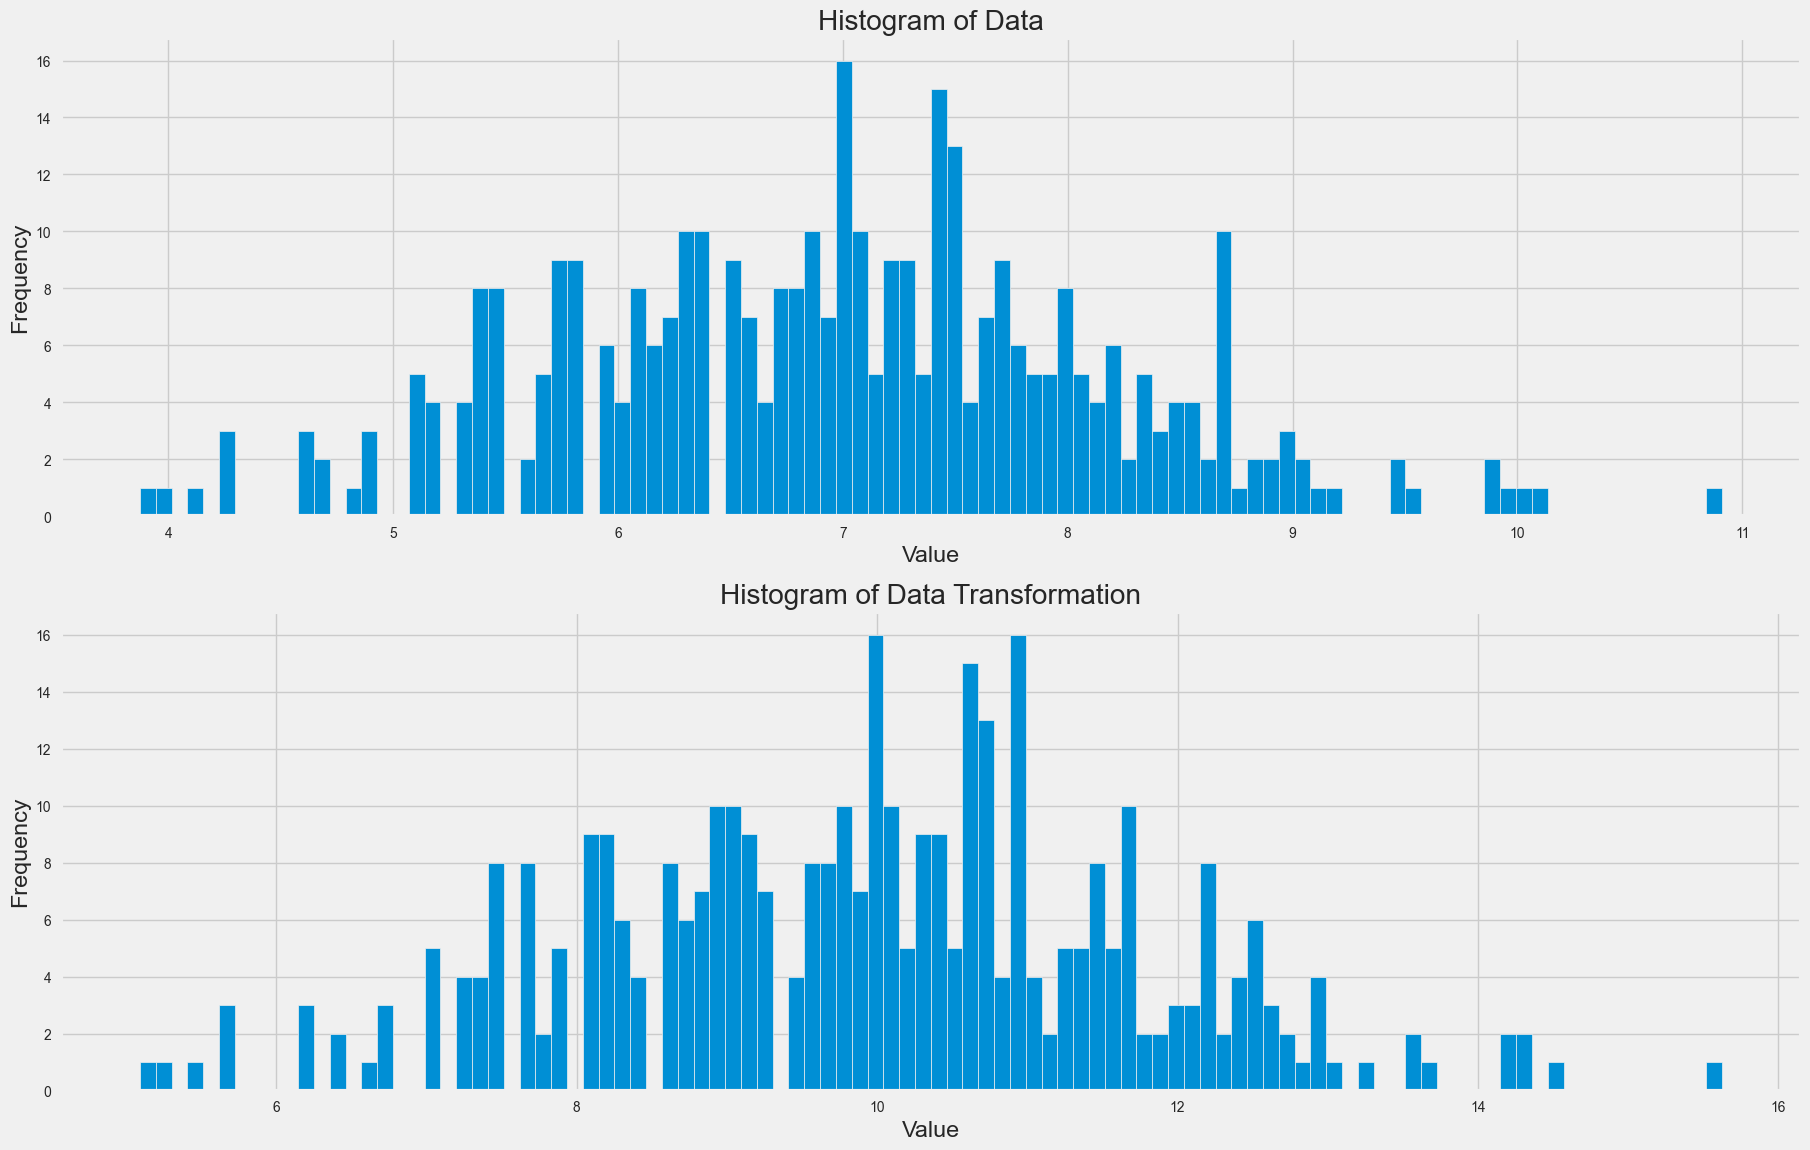

In [158]:
# Plot the histogram
plt.figure(figsize=(20,13))

plt.subplot(2, 1, 1)
plt.hist(df_arima['Qty'], bins=100)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data")

plt.subplot(2, 1, 2)
plt.hist(df_transform['Qty'], bins=100)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Data Transformation")
plt.show()

##### Uji Stasioner

In [159]:
# definisikan fungsi untuk melakukan ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Hasil Uji: Data residu bersifat stasioner.")
    else:
        print("Hasil Uji: Data residu tidak bersifat stasioner.")

adf_test(df_arima)

ADF Statistic: -19.789910
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.870
	10%: -2.571
Hasil Uji: Data residu bersifat stasioner.


 ### Pemodelan

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1601.433, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1401.802, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1471.078, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1373.291, Time=0.28 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.31 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1482.214, Time=0.50 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1339.784, Time=1.03 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1378.534, Time=0.14 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.15 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.63 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1302.938, Time=0.44 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC=1341.777, Time=0.19 sec
 ARIMA(3,1,0)(2,1,1)[12]             : AIC=i

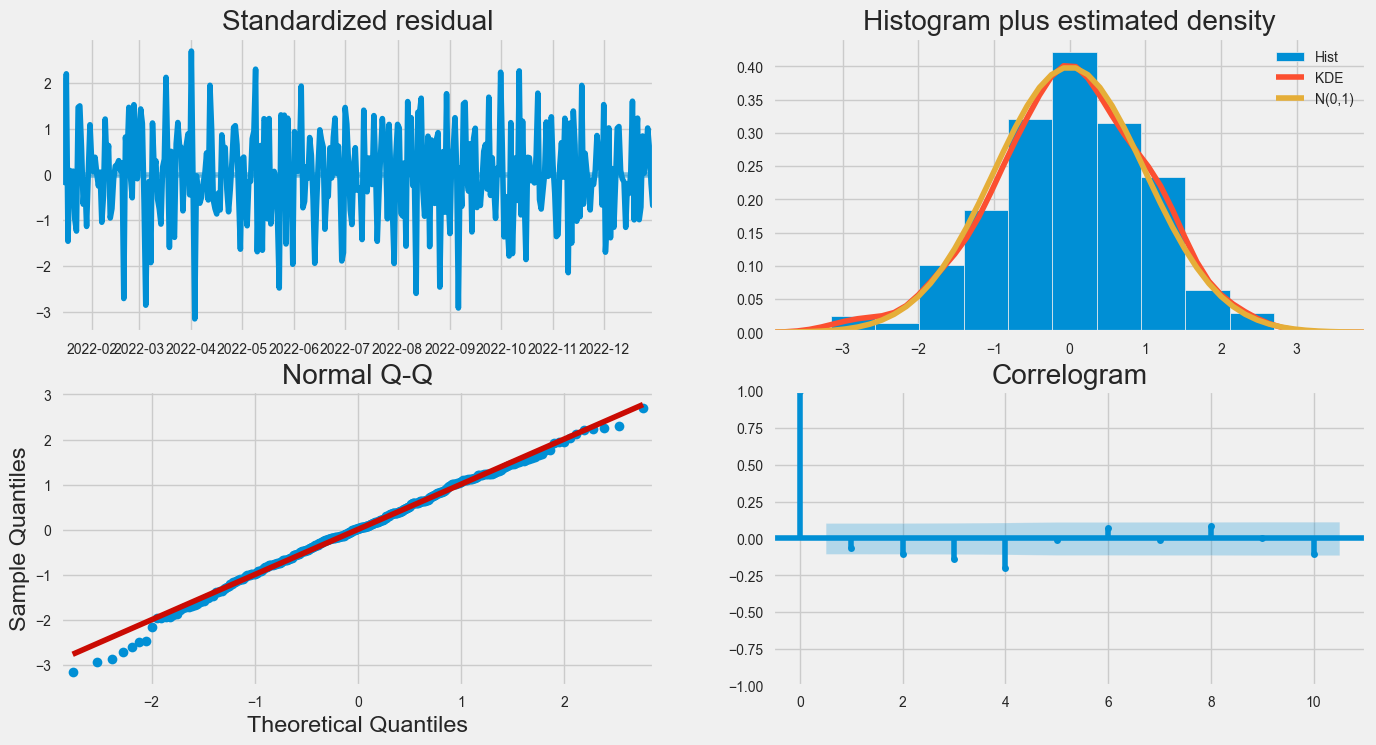

In [160]:
model_autoARIMA = pm.auto_arima(df_arima, start_p=0, start_q=0,
                             test='adf',       # use adftest to find optimal 'd'
                             max_p=3, max_q=3, # maximum p and q
                             m=12,              # frequency of series
                             d=1,           # let model determine 'd'
                             seasonal=True,   # With Seasonality
                             start_P=0,
                             D=1,
                             start_Q=0,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

##### Asumsi Hasil Pemodelan

1. Asumsi tentang Autokorelasi:

Hasil uji Ljung-Box (Q) menunjukkan nilai 1.34 dengan Prob(Q) sebesar 0.25.
Nilai Prob(Q) yang tinggi menunjukkan bahwa tidak ada cukup bukti untuk menolak hipotesis nol bahwa tidak ada autokorelasi dalam sisa (residuals) model.
Oleh karena itu, model SARIMA memenuhi asumsi tentang autokorelasi, karena tidak ada cukup bukti untuk menolak bahwa residual model bebas dari autokorelasi.


2. Asumsi tentang Distribusi Residual:

Hasil uji Jarque-Bera (JB) menunjukkan nilai 3.72 dengan Prob(JB) sebesar 0.16.
Nilai Prob(JB) yang tinggi menunjukkan bahwa tidak ada cukup bukti untuk menolak hipotesis nol bahwa data residu berasal dari distribusi normal.
Oleh karena itu, model SARIMA juga memenuhi asumsi tentang distribusi residu, karena tidak ada cukup bukti untuk menolak bahwa residu berasal dari distribusi normal.


3. Asumsi tentang Heteroskedastisitas:

Hasil uji Heteroskedastisitas menunjukkan nilai 0.91 dengan Prob(H) (two-sided) sebesar 0.6.
Nilai Prob(H) yang tinggi menunjukkan bahwa tidak ada cukup bukti untuk menolak hipotesis nol bahwa residu model homoskedastik (variansi konstan).
Oleh karena itu, model SARIMA juga memenuhi asumsi tentang homoskedastisitas residu, karena tidak ada cukup bukti untuk menolak bahwa residu memiliki variansi konstan.

### Prediksi Model Terbaik

##### Train Test Split

In [161]:
train, test = train_test_split(df_arima, train_size=0.8)

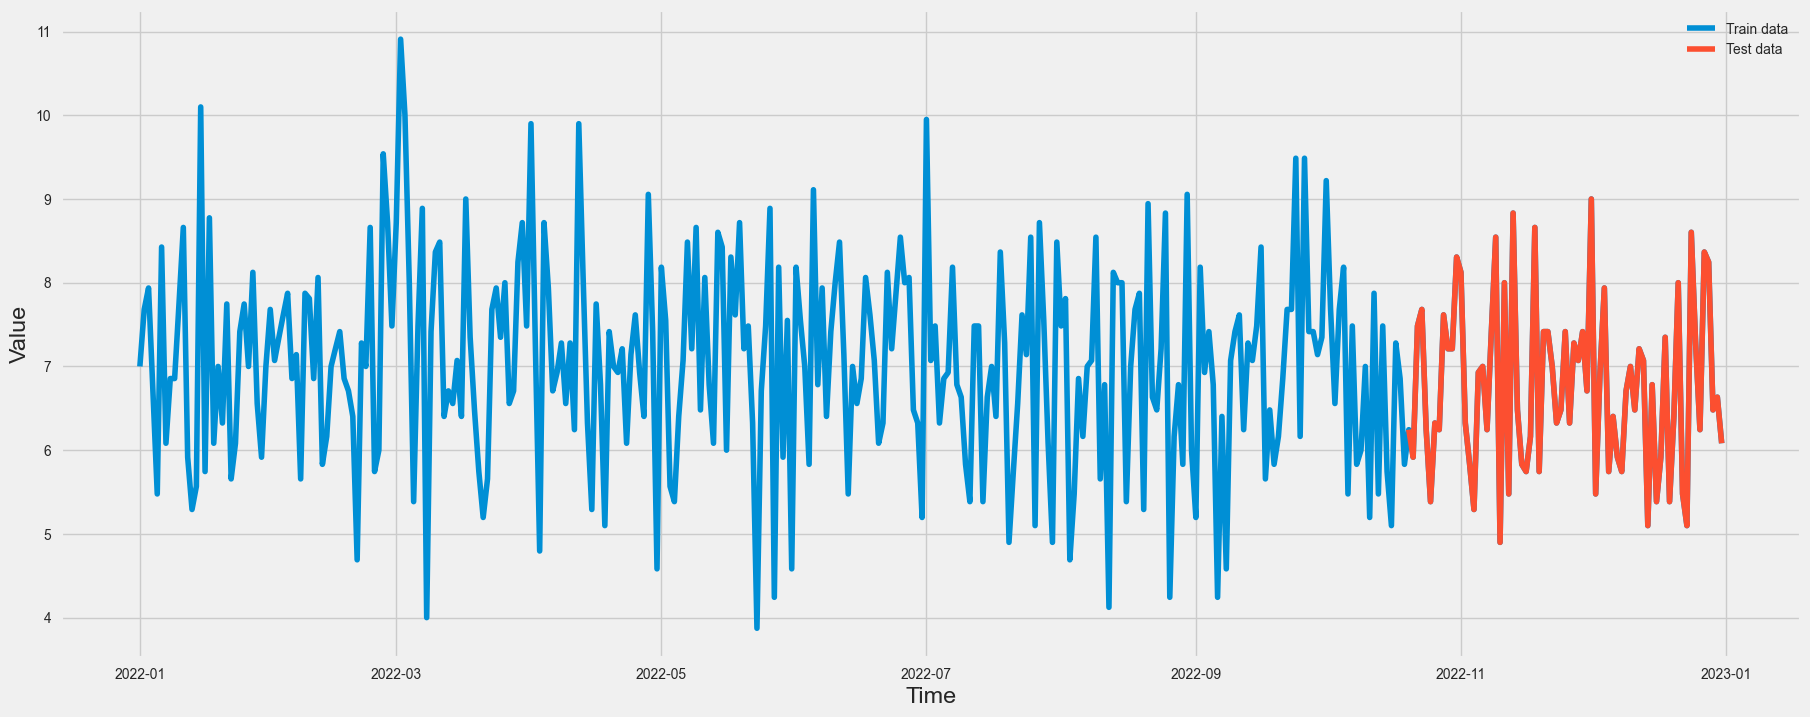

In [162]:
plt.figure(figsize=(20,8))
plt.grid(True)
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(df_arima, label='Train data')
plt.plot(test,label='Test data')
plt.legend()

#### Model Fitting

In [163]:
# Assuming 'df_arima' is your time series data (e.g., a pandas DataFrame or Series)
# Set the frequency of the data appropriately (e.g., 'D' for daily, 'M' for monthly, etc.)
# Change 'freq' to the appropriate frequency of your data
df_arima = df_arima.asfreq(freq='D')

# Using the same parameters of the fitted model
# Order based on SARIMA Model with the smallest AIC value
best_model = sm.tsa.statespace.SARIMAX(df_arima, order=(3, 1, 0), seasonal_order=(2, 1, 0, 12), trend='c')

# Fitting the SARIMA model to the data
best_result = best_model.fit(disp=True)


In [164]:
best_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                Qty   No. Observations:                  365
Model:             SARIMAX(3, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -645.467
Date:                            Sat, 29 Jul 2023   AIC                           1304.934
Time:                                    21:46:37   BIC                           1331.979
Sample:                                01-01-2022   HQIC                          1315.697
                                     - 12-31-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0053      0.085      0.062      0.950      -0.162       0.173
ar.L1         -0.7841      0.055    -14.315      0.000      -0.891      -0.677
ar.L2         -0.5360      0.067     -7.970      0.000      -0.668      -0.404
ar.L3         -0.3263      0.058     -5.671      0.000      -0.439      -0.214
ar.S.L12      -0.6192      0.054    -11.378      0.000      -0.726      -0.513
ar.S.L24      -0.3412      0.053     -6.416      0.000      -0.445      -0.237
sigma2         2.2492      0.167     13.458      0.000       1.922       2.577
===================================================================================
Ljung-Box (L1) (Q):                   1.34   Jarque-Bera (JB):                 3.72
Prob(Q):                              0.25   Prob(JB):                         0.16
Heteroskedasticity (H):               0.91   Skew:                            -0.24
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [165]:
test['Predict'] = best_result.predict(start=(len(train)), end=(len(train)+len(test)+2))

In [166]:
best_result_residual = best_result.resid

##### Prediksi Data Test

In [167]:
test['Predict']

Date
2022-10-20    6.080841
2022-10-21    6.196167
2022-10-22    6.886335
2022-10-23    5.017742
2022-10-24    7.073290
                ...   
2022-12-27    6.846655
2022-12-28    7.364044
2022-12-29    6.781394
2022-12-30    7.654265
2022-12-31    7.083501
Name: Predict, Length: 73, dtype: float64

In [172]:
import plotly.graph_objects as go

# Create a Plotly figure
fig = go.Figure()

# Add trace for the actual values
fig.add_trace(go.Scatter(x=df_arima.index, y=df_arima['Qty'], mode='lines', name='Expected Values'))

# Add trace for the predicted values
fig.add_trace(go.Scatter(x=test.index, y=test['Predict'], mode='lines', name='Predicted Values'))

# Update layout
fig.update_layout(title='ARIMA Model: Expected vs. Predicted Values',
                  xaxis_title='Date', yaxis_title='Qty')

# Show the plot
fig.show()


##### Evaluasi Model

In [173]:
# Calculate the evaluation metrics
mae = np.mean(np.abs(best_result_residual))
mse = np.mean(best_result_residual**2)
rmse = np.sqrt(mse)
mape = np.mean(np.abs(best_result_residual / df_arima['Qty'])) * 100
mad = sm.robust.scale.mad(best_result_residual)
# Print the evaluation metrics
print('MAE:', mae)
print("MAPE:", mape)
print('MSE:', mse)
print('RMSE:', rmse)
print('MAD:', mad)

MAE: 1.2194960407824955
MAPE: 18.519703626552094
MSE: 2.48424300362385
RMSE: 1.5761481540844597
MAD: 1.4746098617774563


#### Prediksi Tahun Depan

In [ ]:
predict_1year = best_result.predict(start=(len(df_arima)), end=(len(df_arima)+11))

In [ ]:
# Mengembalikan nilai y menjadi seperti semula
predict_1year = np.square(predict_1year)
predict_1year

In [ ]:
# Membuat plot
plt.figure(figsize=(10, 6))
plt.plot(predict_1year, label='Prediksi (Qty)', color='blue')

# Tambahkan judul dan label sumbu
plt.title('Hasil Prediksi Model Untuk 1 Tahun Depan')
plt.xlabel('Waktu')
plt.ylabel('Qty')

# Menampilkan legenda
plt.legend()

# Tampilkan plot
plt.show()